In [83]:
import torch
import torch.nn as nn
import PIL.Image
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from nyudataset import NYUDepthDataset

In [4]:
class DepthNetV1(nn.Module):
    def __init__(self):
        super(DepthNetV1, self).__init__()

        base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(base_model.children())[:-3])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=1, padding=1),
            nn.ReLU()
        )
    
    def forward(self, X):
        X = self.encoder.forward(X)
        X = self.decoder.forward(X)
        return X

In [5]:
basic_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset_train = NYUDepthDataset(
    root_dir="./nyu_depth_data",
    csv_index="nyu2_train.csv",
    transform=basic_transform
)

dataset_test = NYUDepthDataset(
    root_dir="./nyu_depth_data",
    csv_index="nyu2_test.csv",
    transform=basic_transform
)

dataloader_train = torch.utils.data.DataLoader(
    dataset=dataset_train,
    batch_size=64,
    shuffle=True,
    num_workers=4
)

dataloader_test = torch.utils.data.DataLoader(
    dataset=dataset_test,
    batch_size=64,
    shuffle=True,
    num_workers=4
)

In [6]:
model = torch.load(
    "./models/DepthNetV1-TV2.pth",
    weights_only=False,
    map_location=torch.device("cpu")
)

In [32]:
model.eval()

X_train, y_train = next(iter(dataloader_train))
y_pred_train = model.forward(X_train)

X_test, y_test = next(iter(dataloader_test))
y_pred_test = model.forward(X_test)

y_pred_train.shape, y_pred_test.shape

(torch.Size([64, 1, 256, 256]), torch.Size([64, 1, 256, 256]))

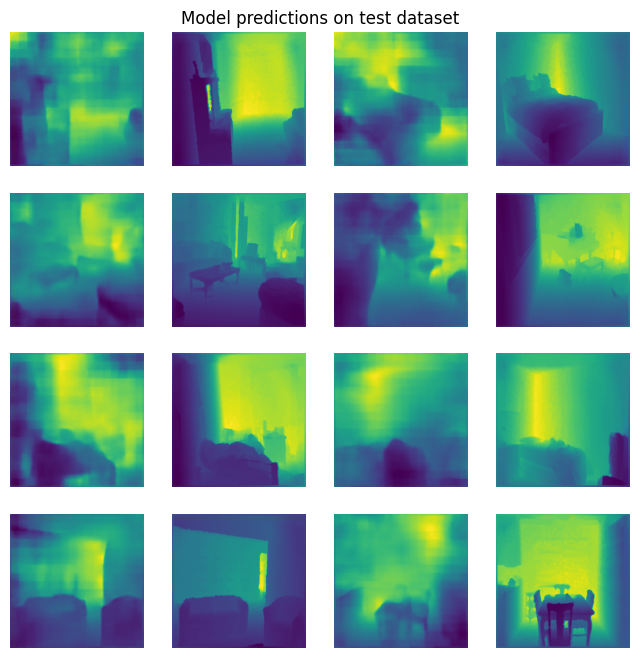

In [9]:
plt.figure(figsize=(8, 8))
plt.title("Model predictions on test dataset")
plt.axis(False)

image_index = 0
for i in range(1, 4 * 4, 4):
    image_index += 1

    plt.subplot(4, 4, i)
    plt.imshow(y_pred_test[image_index].detach().permute(1, 2, 0))
    plt.axis(False)

    plt.subplot(4, 4, i+1)
    plt.imshow(y_test[image_index].detach().permute(1, 2, 0))
    plt.axis(False)

    image_index += 1

    plt.subplot(4, 4, i+2)
    plt.imshow(y_pred_test[image_index].detach().permute(1, 2, 0))
    plt.axis(False)

    plt.subplot(4, 4, i+3)
    plt.imshow(y_test[image_index].detach().permute(1, 2, 0))
    plt.axis(False)

plt.show()

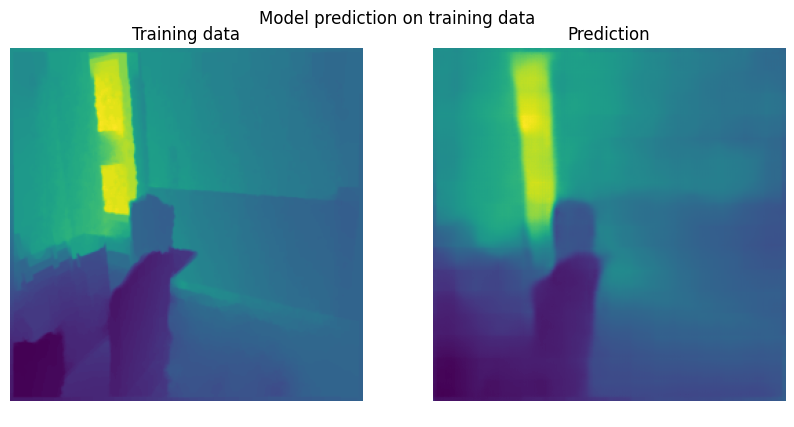

In [117]:
image_train = y_train[25].squeeze().numpy() / 4157
image_pred = y_pred_train[25].detach().squeeze().numpy()

plt.figure(figsize=(10, 5))
plt.title("Model prediction on training data")
plt.axis(False)

plt.subplot(1, 2, 1)
plt.title("Training data")
plt.imshow(image_train)
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title("Prediction")
plt.imshow(image_pred)
plt.axis(False)

np.save("./predictions/heatmap-train-data.npy", image_train)
np.save("./predictions/heatmap-train-pred.npy", image_pred)

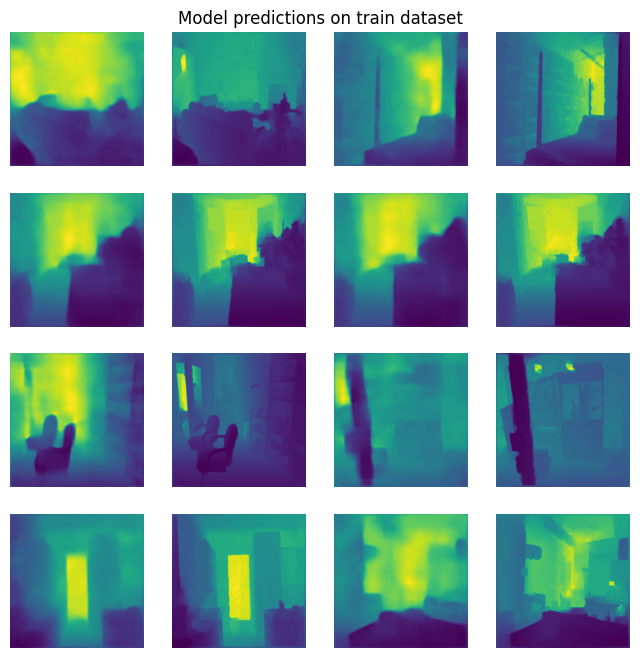

In [10]:
plt.figure(figsize=(8, 8))
plt.title("Model predictions on train dataset")
plt.axis(False)

image_index = 0
for i in range(1, 4 * 4, 4):
    image_index += 1

    plt.subplot(4, 4, i)
    plt.imshow(y_pred_train[image_index].detach().permute(1, 2, 0))
    plt.axis(False)

    plt.subplot(4, 4, i+1)
    plt.imshow(y_train[image_index].detach().permute(1, 2, 0))
    plt.axis(False)

    image_index += 1

    plt.subplot(4, 4, i+2)
    plt.imshow(y_pred_train[image_index].detach().permute(1, 2, 0))
    plt.axis(False)

    plt.subplot(4, 4, i+3)
    plt.imshow(y_train[image_index].detach().permute(1, 2, 0))
    plt.axis(False)

plt.show()

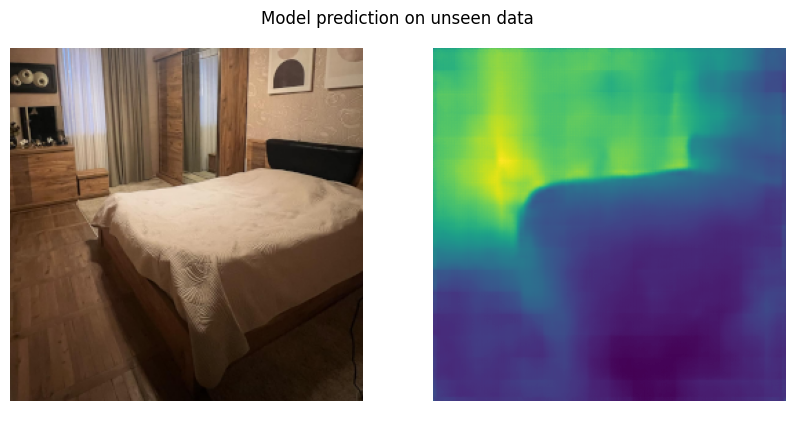

In [120]:
raw_image = PIL.Image.open("./predictions/inference-preview-rgb.png")
image = basic_transform(raw_image)[:3]

y_pred = model.forward(image.unsqueeze(dim=0)).detach()

plt.figure(figsize=(10, 5))
plt.title("Model prediction on unseen data")
plt.axis(False)

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(y_pred.squeeze())
plt.axis(False)

np.save("./predictions/inference-preview-pred.npy", y_pred.squeeze().numpy())